# README

This takes the data generated from gen_npWindow_data.py and converts it into graphs. This experiment is taking 12 curves where there are windows around the null points. These windows around the null points are varied to show how close we need to be to the null point to have improved MSE beyond the conventional method

# Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [2]:


cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'Window1D_SNR_Data'
exp_date = '28Nov23'

spacing = 15           #how far did the windows spread around center --> 2*spacing
method = "AIC"

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

/home/hamptong2/


In [3]:
with open(f'{cwd_full}{base_file}/Espresso_Method/{exp_file}/hprParameter_{method}_sp_{spacing}_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    rad_diff = dict['rad_diff']
    center_array = dict['center_array']
    SNR_values = dict["SNR_values"]
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    AIC_eval_iter = dict['AIC_eval_iter']
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

### Standard Analysis

In [12]:
SR_folder = 'Comparison_DATA'
SR_date = '29Nov23'

In [13]:
with open(f'{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/hprParameter_AIC_SNRsuite_large_{SR_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SR_SNR_values = dict["SNR_values"]
    SR_true_params = dict["true_params"]
    SR_TI_STANDARD = dict["TI_DATA"]
    SR_nTE = dict["nTE"]
    SR_dTE = dict["dTE"]
    SR_var_reps = dict["var_reps"]
    SR_AIC_eval_iter = dict['AIC_eval_iter']
    SR_multi_start = dict['multi_start']
    handle.close()


for iter in range(len(true_params)):
    assert(SR_true_params[iter] == true_params[iter])

for iter in range(len(SNR_values)):
    assert(SR_SNR_values[iter] == SNR_values[iter])

[ 50  55  60  65  70  75  80  85  90  95 100 105 110 115 120 125 130 135
 140 145]
[ 50  55  60  65  70  75  80  85  90  95 100 105 110 115 120 125 130 135
 140 145]


# Functions

In [14]:
def to_readable_1DWindow(file):
    df = pd.read_pickle(file)
    ALL_CENTER = np.stack(df["Center"].values) #shape: (len(center_diff_range))
    ALL_SNR = np.stack(df["SNR"].values) #shape: (len(center_diff_range))
    ALL_TI = np.stack(df["TI_DATA"].values) #shape: (len(center_diff_range), len(TI))
    ALL_SNR_eTime = np.stack(df["SNR_eTime"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))
    ALL_AIC = np.stack(df["AIC"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_CENTER, ALL_SNR, ALL_TI, ALL_SNR_eTime, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC, ALL_pEst_AIC, ALL_pEst_cf

def to_readable_SR(file):
    df = pd.read_pickle(file)
    ALL_SNR = np.stack(df["SNR"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))
    ALL_AIC = np.stack(df["AIC"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_SNR, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC, ALL_pEst_AIC, ALL_pEst_cf


def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

In [19]:
def prepare_data(p_oi):

    MSE_ordered = np.zeros((len(center_array), len(SNR_values), 3)) # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    var_ordered = np.zeros((len(center_array), len(SNR_values), 3))
    bias_ordered = np.zeros((len(center_array), len(SNR_values), 3))
    AIC_ordered = np.zeros((len(center_array), len(SNR_values), 12))

    eqSNR_ordered = np.zeros((len(center_array), len(SNR_values)))
    TI_ordered = np.zeros((len(center_array), len(SNR_values), 12))

    pEst_AIC_ordered = np.zeros((len(center_array), len(SNR_values), var_reps, len(ParamTitle_6p)))
    pEst_cf_ordered = np.zeros((len(center_array), len(SNR_values), var_reps, len(ParamTitle_6p)))

    data_name = f"{cwd_full}{base_file}/Espresso_Method/{exp_file}/Window1D_{method}_sp_{spacing}_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    Center, SNR, TI_DATA, eqSNR, MSE, VAR, BIAS, AIC, pEst_AIC, pEst_cf = to_readable_1DWindow(data_name)

    for index in range(len(MSE)):

        temp_center = Center[index]

        temp_SNR = SNR[index]

        center_index = np.where(temp_center==center_array)[0][0]
        SNR_index = np.where(temp_SNR==SNR_values)[0][0]

        AIC_ordered[center_index, SNR_index,:] = AIC[index, :]/var_reps
        MSE_ordered[center_index, SNR_index,:] = MSE[index,:,p_oi]
        var_ordered[center_index, SNR_index,:] = VAR[index,:,p_oi]
        bias_ordered[center_index, SNR_index,:] = BIAS[index,:,p_oi]
        eqSNR_ordered[center_index, SNR_index,] = eqSNR[index]
        TI_ordered[center_index, SNR_index,:] = TI_DATA[index,:]
        pEst_AIC_ordered[center_index, SNR_index,:,:] = pEst_AIC[index,:,:]
        pEst_cf_ordered[center_index, SNR_index,:,:] = pEst_cf[index,:,:]

    return MSE_ordered, var_ordered, bias_ordered, AIC_ordered, eqSNR_ordered, TI_ordered, pEst_AIC_ordered, pEst_cf_ordered

# Data Organization

In [20]:
MSE, var, bias, AIC, SNRs, TI_DATAs, pEst_AIC, pEst_cf = prepare_data(param_oi)

SR_name = f"{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/SNRsuite_large_{SR_date}.pkl"
SR_SNR, SR_MSE, SR_VAR, SR_BIAS, SR_AIC, SR_pEst_AIC, SR_pEst_cf = to_readable_SR(SR_name)

Retrieving data for /home/hamptong2/Stabilization/Espresso_Method/Window1D_SNR_Data/Window1D_AIC_sp_15_28Nov23.pkl


# Figures

In [26]:
def MSE_plot(centers, MSE_mat, SR_MSE_val, COFFEE_MSE, SNR_val, param_oi):
    fig, ax = plt.subplots(1, 1, figsize=(5,4.5), tight_layout=True)
    fig.suptitle(f"MSE Measurements of {ParamTitle_6p[param_oi]}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]\nSNR = {SNR_val}")

    plt.plot(center_array, MSE_mat, label = "ESPRESSO", color = 'b', lw = 2)
    plt.axhline(y = COFFEE_MSE[param_oi], label = "logspaced COFFEE", color = "r", lw = 2)
    plt.axhline(y = SR_MSE_val[param_oi], label = "logspaced conventional", color = "g", lw = 2)

    plt.xlabel(r'Null Point Guess Offset')
    plt.ylabel("MSE")
    plt.legend()

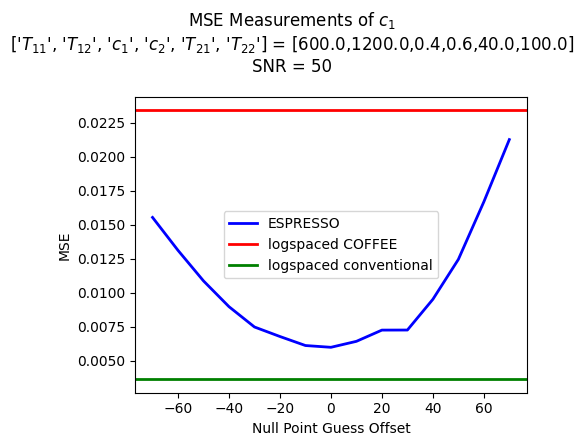

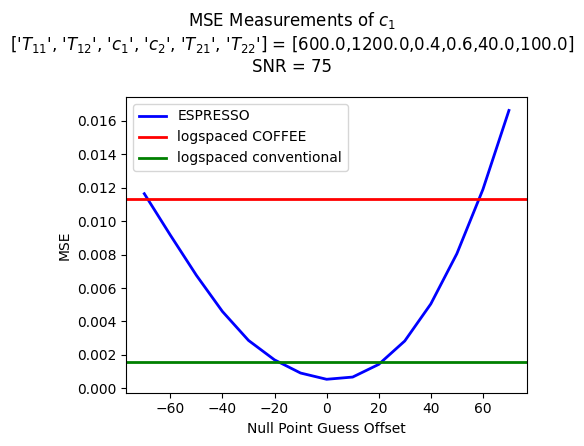

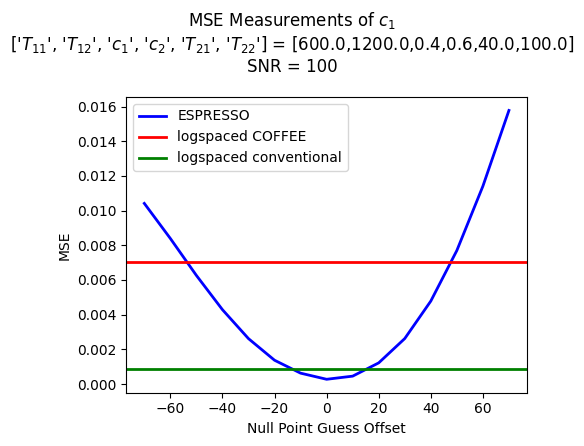

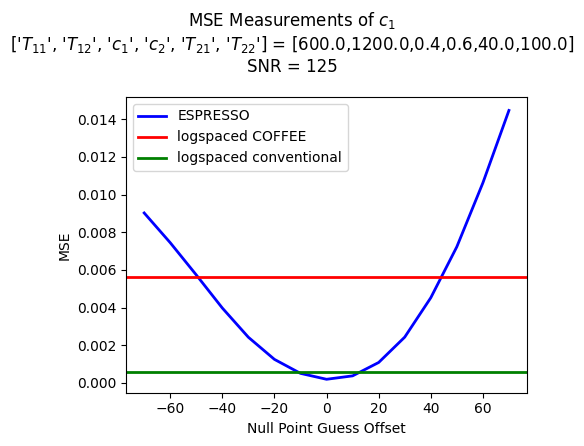

In [59]:
SNR_oi = [50, 75, 100, 125]
for elem in SNR_oi:
    assert(elem in SNR_values)

for iSNR in SNR_oi:

    SR_SNR_index = np.where(SR_SNR==iSNR)[0][0]
    SNR_index = np.where(SNR_values==iSNR)[0][0]

    MSE_ESPRESSO = MSE[:,SNR_index, 0]

    MSE_SR = SR_MSE[SR_SNR_index, -1, :]
    MSE_COFFEE = SR_MSE[SR_SNR_index, 0, :]

    MSE_plot(center_array, MSE_ESPRESSO, MSE_SR, MSE_COFFEE, iSNR, param_oi)

In [54]:
hold = np.zeros(len(SNR_values))

for iSNR in range(len(SNR_values)):
    SR_SNR_index = np.where(SR_SNR==SNR_values[iSNR])[0]


    MSE_ESPRESSO = MSE[:,iSNR, 0]

    MSE_SR = SR_MSE[SR_SNR_index, -1, param_oi]

    # print(MSE_ESPRESSO - MSE_SR)

    value = np.argwhere(np.diff(np.sign(MSE_ESPRESSO - MSE_SR))).reshape(-1)
    if value.shape[0] > 0:
        ratio_1 = np.abs(MSE_SR - MSE_ESPRESSO[value[0]])/np.abs(MSE_ESPRESSO[value[0]+1] - MSE_ESPRESSO[value[0]])
        intersect_1 = ratio_1*np.abs(center_array[value[0]+1] - center_array[value[0]]) + center_array[value[0]]
        
        ratio_2 = np.abs(MSE_SR - MSE_ESPRESSO[value[1]])/np.abs(MSE_ESPRESSO[value[1]+1] - MSE_ESPRESSO[value[1]])
        intersect_2 = ratio_2*np.abs(center_array[value[1]+1] - center_array[value[1]]) + center_array[value[1]]

        hold[iSNR] = intersect_2 - intersect_1



/tmp/ipykernel_1285641/1398151014.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hold[iSNR] = intersect_2 - intersect_1


Text(0.5, 0, 'SNR Value')

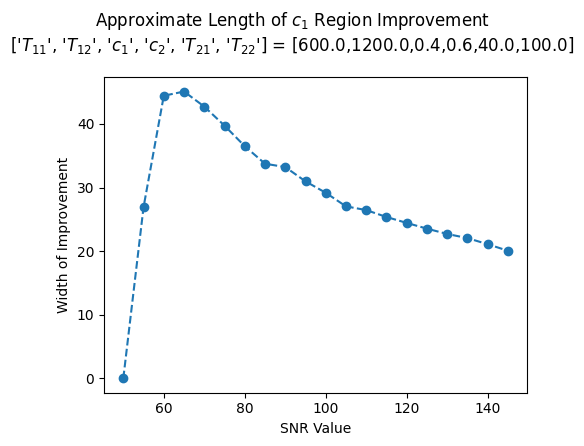

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(5,4.5), tight_layout=True)
fig.suptitle(f"Approximate Length of {ParamTitle_6p[param_oi]} Region Improvement\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")
plt.plot(SNR_values, hold, marker = 'o', ls = '--')
plt.ylabel("Width of Improvement")
plt.xlabel("SNR Value")

Text(0.5, 0, 'Center of Null Point Window - Precent of Null Point')

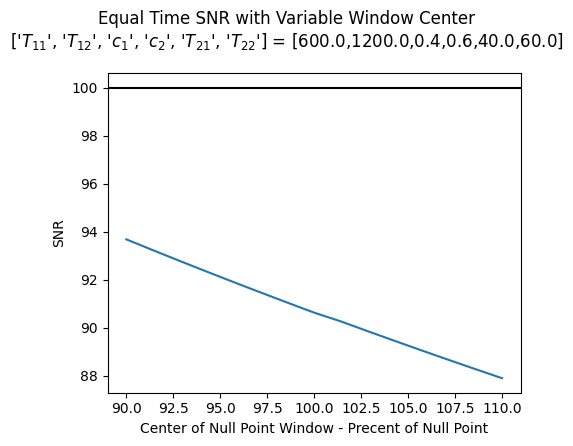

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4.5), tight_layout=True)
fig.suptitle(f"Equal Time SNR with Variable Window Center\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")
plt.plot(center_array*100, SNRs, label = "Equal Time")
plt.axhline(y = SR_SNR, color = 'k', label = "Standard SNR")
plt.ylabel("SNR")
plt.xlabel("Center of Null Point Window - Precent of Null Point")

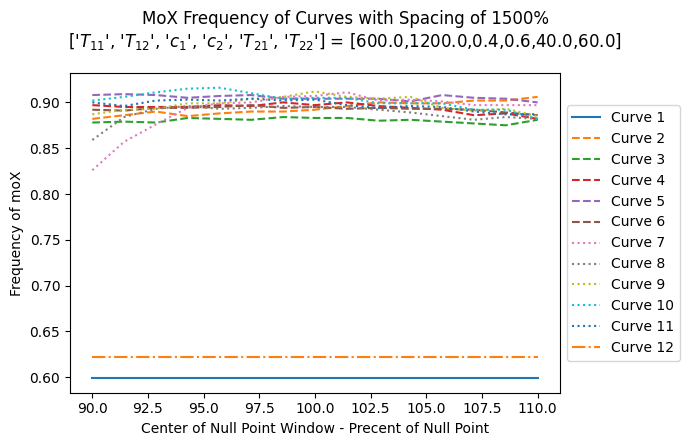

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,4.5), tight_layout=True)
fig.suptitle(f"MoX Frequency of Curves with Spacing of {spacing*100}%\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")
for i in range(AIC.shape[1]):
    if i == 0 :
        plt.plot(center_diff_array*100, AIC[:,i], label = f'Curve {i+1}', ls = '-')
    elif i < 5+1 :
        plt.plot(center_diff_array*100, AIC[:,i], label = f'Curve {i+1}', ls = '--')
    elif i < 2*5+1 :
        plt.plot(center_diff_array*100, AIC[:,i], label = f'Curve {i+1}', ls = ':')
    else:
        plt.plot(center_diff_array*100, AIC[:,i], label = f'Curve {i+1}', ls = '-.')

plt.xlabel("Center of Null Point Window - Precent of Null Point")
plt.ylabel("Frequency of moX")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Text(0.5, 1.0, 'Null Point 2')

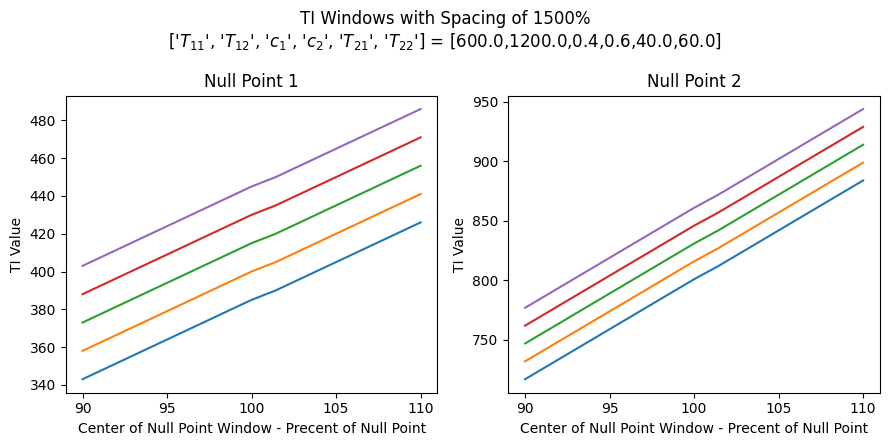

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,4.5), tight_layout=True)
fig.suptitle(f"TI Windows with Spacing of {spacing*100}%\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")
for i in range(5):
    ax[0].plot(center_diff_array*100, TI_DATAs[:,i+1], label = f'Curve {i+1}')
    ax[1].plot(center_diff_array*100, TI_DATAs[:,i+6], label = f'Curve {i+6}')

ax[0].set_xlabel("Center of Null Point Window - Precent of Null Point")
ax[1].set_xlabel("Center of Null Point Window - Precent of Null Point")
ax[0].set_ylabel("TI Value")
ax[1].set_ylabel("TI Value")

ax[0].set_title("Null Point 1")
ax[1].set_title("Null Point 2")

